### INFO284 Machine Learning Exam, spring 2024 
Przybys & Peter


### Table of contents
1. [Introduction](#introduction)
2. [Project Setup](#project-setup)
2. [Exploring Data](#exploring-data)
3. [Data Preprocessing](#data-preprocessing)
4. [Feature Engineering](#feature-engineering)
5. [Modeling](#modeling)
6. [Evaluation](#evaluation)
7. [Conclusion](#conclusion)
8. [References](#references)


### Introduction <a name="introduction"></a> (136)

This report is about machine learning on fisheries data from Norwegian Directorate of Fisheries. The dataset is from 2018 and several of the original columns have already been removed by our lecturer to create a better reference point. The main objective with our models has been to predict the “Rundvekt” continuous values on species “Torsk”, “Sei, and “Hyse”. This is categorized as a quantitative regression problem and our group has been working according to relevant principles within such a problem space. The report will include reasoning for choices made within data exploration, preprocessing, feature engineering, and the use of the specific machine learning models implemented. The project will implement three supervised machine learning models, including one deep learning model. Additionally, we will develop an unsupervised clustering model, for which a distinct data preprocessing approach is permitted.

### Project Setup <a name="project-setup"></a>

##### Importing and versioncontrol for our choosen libraries

In [1]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]


pandas version: 2.2.2
matplotlib version: 3.8.4
NumPy version: 1.26.4
SciPy version: 1.13.0
IPython version: 8.23.0
scikit-learn version: 1.4.2
seaborn version: 0.13.2


#### Importing the dataset

In [2]:
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
# Keep in mind that the file is encoded in UTF-8 so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")

Before pre-processing the dataset has 45 columns and 305434 rows


### Exploring Data <a name="exploring-data"></a> (125)


Regarding our problem space we already inherit some knowledge about what datatype we want to work with. So intuitively we know that numerical values will be more relevant than categorical values. It is important not to let this control the data exploration too much, and to take important choices which could be wrong. The data exploration will be about investigating and building the foundation for the reasoning regarding the preprocessing and cleaning of data. At first glance there are 45 columns and 305433 rows. Initially more data is very useful for our deep learning model, but after analyzing various columns there is a large amount of redundancy, 370703 total missing values, wrong datatypes and plenty of categorical data which may not be relevant for us.

In [3]:
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                305434 non-null  int64  
 1   Meldingstidspunkt         305434 non-null  object 
 2   Meldingsdato              305434 non-null  object 
 3   Meldingsklokkeslett       305434 non-null  object 
 4   Starttidspunkt            305434 non-null  object 
 5   Startdato                 305434 non-null  object 
 6   Startklokkeslett          305434 non-null  object 
 7   Startposisjon bredde      305434 non-null  object 
 8   Startposisjon lengde      305434 non-null  object 
 9   Hovedområde start (kode)  303433 non-null  float64
 10  Hovedområde start         301310 non-null  object 
 11  Lokasjon start (kode)     303433 non-null  float64
 12  Havdybde start            305434 non-null  int64  
 13  Stopptidspunkt            305434 non-null  o

In [5]:
df.isnull().sum().sum()

370703

In [6]:
df.isnull().sum()

Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)      2001
Hovedområde start             4124
Lokasjon start (kode)         2001
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)      1962
Hovedområde stopp             4124
Lokasjon stopp (kode)         1962
Havdybde stopp                   0
Trekkavstand                    24
Redskap FAO (kode)               0
Redskap FAO                    188
Redskap FDIR (kode)            188
Redskap FDIR        

In [7]:
#checking for redundant columns
df.nunique()

Melding ID                  49437
Meldingstidspunkt           44411
Meldingsdato                  366
Meldingsklokkeslett          1440
Starttidspunkt              89322
Startdato                     375
Startklokkeslett             1440
Startposisjon bredde        18063
Startposisjon lengde        35508
Hovedområde start (kode)       56
Hovedområde start              55
Lokasjon start (kode)          83
Havdybde start               2375
Stopptidspunkt              89701
Stoppdato                     366
Stoppklokkeslett             1440
Varighet                     4593
Fangstår                        2
Stopposisjon bredde         18193
Stopposisjon lengde         35871
Hovedområde stopp (kode)       57
Hovedområde stopp              55
Lokasjon stopp (kode)          82
Havdybde stopp               2378
Trekkavstand                31409
Redskap FAO (kode)             31
Redskap FAO                    30
Redskap FDIR (kode)            17
Redskap FDIR                   17
Hovedart FAO (

In [8]:
print(df['Art FAO'].value_counts())
print(df['Art - FDIR'].value_counts())
print(df['Art - gruppe'].value_counts())
print(df['Hovedart FAO'].value_counts())

Art FAO
Torsk                  56574
Sei                    42557
Hyse                   39120
Lange                  17338
Uer (vanlig)           14153
                       ...  
Sagtang                    1
Annen makrell              1
Blåhval                    1
Annen laksefisk            1
Bukstripet pelamide        1
Name: count, Length: 122, dtype: int64
Art - FDIR
Torsk                  56574
Sei                    42557
Hyse                   39120
Lange                  17338
Uer (vanlig)           14153
                       ...  
Sagtang                    1
Annen makrell              1
Blåhval                    1
Annen laksefisk            1
Bukstripet pelamide        1
Name: count, Length: 122, dtype: int64
Art - gruppe
Torsk                                       56574
Annen torskefisk                            45286
Sei                                         42557
Hyse                                        39120
Annen flatfisk, bunnfisk og dypvannsfisk    25267
Ue

dropp kommentarer. except for tekniske ting
vise dataen underveis
dropna, påstander om hvorfor vi dropper de, bevis 
vise distribusjon av outliers
fillNA, groupBy, meldingsid, startstidspunkt
robustScaler, hvorfor vi bruker det, outliers
scalingData for modellene, forklar
gradientBoosting, scaling data hvorfor? Bedre optimum, forklare MultioutputRegressor
MLPR, not converging, learning rate importances
viktig train validation og test splits,
forklare typene features, 
skaleringen fit skal bare være på treningsdataen, skalering skal kun være minste og største verdiene i treningsdataen. 
scaler.fit()transform på treningsdataen
validationset ikke hellig, testdata = helt skjult frem til eksamen.
scaler.fit på testset

#### Choosing target and pre-prossesing
After taking some time to understand the data we have chosen our target features to be the catches of Hyse, Torsk and Sei as continuous values. Next we will pre-prosess the data so it is ready for modeling.

In [9]:
# Using the same seed for testing purposes makes the results more comparable
seed = 32

In [10]:
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


In [11]:
# Excluding irrelevant columns

# Fangstår has only 2 unique values
df.drop(columns = ['Fangstår'], inplace= True)

# Lengdegruppe (kode), Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde all seem to be speaking of the boat doing the catching, with few unique values in each column.
# One of them should be kept as a feature, the rest discarded. We would suggest the most relevant to be Bruttotonasje, which speaks to how much cargo space there is.
# "Bruttotonnasje 1969" and "Bruttotonnasje annen" seem to have nan where the other one has a value, so first we will collapse them into one.
df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969", "Lengdegruppe", 'Bredde'], inplace=True)

# All columns (kode) in them are cateogrical code representations of another column. For human-readability and to avoid mistaking the code for a continuous value we will remove them.
df.drop(columns=["Hovedområde start (kode)", "Lokasjon start (kode)", "Hovedområde stopp (kode)", "Lokasjon stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Hovedart - FDIR (kode)", "Art FAO (kode)", "Art - FDIR (kode)", "Art - gruppe (kode)", ], inplace = True)

# In both the "Redskap" and "Art" columns you have FAO and FDIR abbriviations. FAO = Food and Agriculture Organization of the United Nations and FDIR = Fiskeridirektoratet
# Due to "Hovedart" onyl having FAO uncoded we will stick to FAO. For the same reason we will remove "Art - gruppe"
df.drop(columns=["Art - gruppe", "Art - FDIR", "Redskap FDIR"], inplace=True)

# The areas where they start and stop have 6 columns. A pair of coordiantes and name of area x2. Since we prefer the continuous features and coordinates=name of place we are removing the name.
df.drop(columns=["Hovedområde start", "Hovedområde stopp"], inplace=True)

# While time of day and date might be relevant we don't need all of them and we don't need to know when it was reported in. For now we will leave start/end date and time.
df.drop(columns=["Meldingsdato", "Meldingsklokkeslett", "Stopptidspunkt"], inplace=True)

# After trying to transform the remaining time columns into continuous values we could use they seemed to have no other effect on the result then longer prosessing time.
df.drop(columns=['Startdato', "Startklokkeslett", "Stoppdato", "Stoppklokkeslett"], inplace=True)

In [12]:
df.head()

,Melding ID,Meldingstidspunkt,Starttidspunkt,Startposisjon bredde,Startposisjon lengde,Havdybde start,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Hovedart FAO,Art FAO,Rundvekt,Lengdegruppe (kode),Fartøylengde,Bruttotonnasje
0,1497177,01.01.2018,31.12.2017,"-60,35","-46,133",-2740,1440,"-60,4","-46,15",-805,5649.0,"Flytetrål, otter",Antarktisk krill,Antarktisk krill,706714.0,5.0,"133,88",9432.0
1,1497178,01.01.2018,30.12.2017 23:21,"74,885","16,048",-335,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Hyse,9594.0,5.0,"56,8",1476.0
2,1497178,01.01.2018,30.12.2017 23:21,"74,885","16,048",-335,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Torsk,8510.0,5.0,"56,8",1476.0
3,1497178,01.01.2018,30.12.2017 23:21,"74,885","16,048",-335,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Blåkveite,196.0,5.0,"56,8",1476.0
4,1497178,01.01.2018,30.12.2017 23:21,"74,885","16,048",-335,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Sei,134.0,5.0,"56,8",1476.0


In [13]:
df.shape

(305434, 18)

In [14]:
# After having checked to see what % of each column had nan values we decided just to drop them as at worst they were around 1.6 %
df = df.dropna()


In [15]:
df.shape

(297281, 18)

In [16]:
# Focusing down on the species we want to investigate
df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [17]:
# Removing parts of columns

# From varighet we remove anyting above 400 as according to lecturer that is in the high range of how long you would be fishing in a session.
# So we will consider them outliers or multiple sessions reported as one and exclude them for now.

df = df[df['Varighet'] <= 400]

# Removing outliers from "Trekkavstand" as above 50000 the frequency gets 100 instances per 5000 length.
df = df[df['Trekkavstand'] <= 30000]

# removing everything below -500 in Havdybde start as it is not possible to have a negative depth. and stoop


In [18]:
df.shape

(100300, 18)

In [19]:
# Manipulating columns

# The coordinates are strings, changing them to int for easier use.
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '').astype(int)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '').astype(int)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '').astype(int)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '').astype(int)

df['Trekkavstand'] = df['Trekkavstand'].astype(int)
df['Bruttotonnasje'] = df['Bruttotonnasje'].astype(int)
df['Varighet'] = df['Varighet'].astype(int)
# df['Startmåned'] = df['Startdato'].astype(str).str[3:5]
# df['Starttime'] = df['Startklokkeslett'].astype(str).str[3:5]
# df['Stoppmåned'] = df['Stoppdato'].astype(str).str[3:5]
# df['Stopptime'] = df['Stoppklokkeslett'].astype(str).str[3:5]

# Many of the sea depth notations are positiv, which doesn't make sense.
# But the amount of them in relation to number of entries means it can't be discounted as an error
# In the lecture on fisheries it was mentioned that a lot fo these are inputed manually
# And that most of these non-sensical sea depths are actually correct, just lacking a minus.
# Therefore we are simply flipping all the positive sea depth into negatives.
df['Havdybde start'] = -df['Havdybde start'].abs()
df['Havdybde stopp'] = -df['Havdybde stopp'].abs()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100300 entries, 1 to 305428
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Melding ID            100300 non-null  int64  
 1   Meldingstidspunkt     100300 non-null  object 
 2   Starttidspunkt        100300 non-null  object 
 3   Startposisjon bredde  100300 non-null  int32  
 4   Startposisjon lengde  100300 non-null  int32  
 5   Havdybde start        100300 non-null  int64  
 6   Varighet              100300 non-null  int32  
 7   Stopposisjon bredde   100300 non-null  int32  
 8   Stopposisjon lengde   100300 non-null  int32  
 9   Havdybde stopp        100300 non-null  int64  
 10  Trekkavstand          100300 non-null  int32  
 11  Redskap FAO           100300 non-null  object 
 12  Hovedart FAO          100300 non-null  object 
 13  Art FAO               100300 non-null  object 
 14  Rundvekt              100300 non-null  float64
 15  Lengd

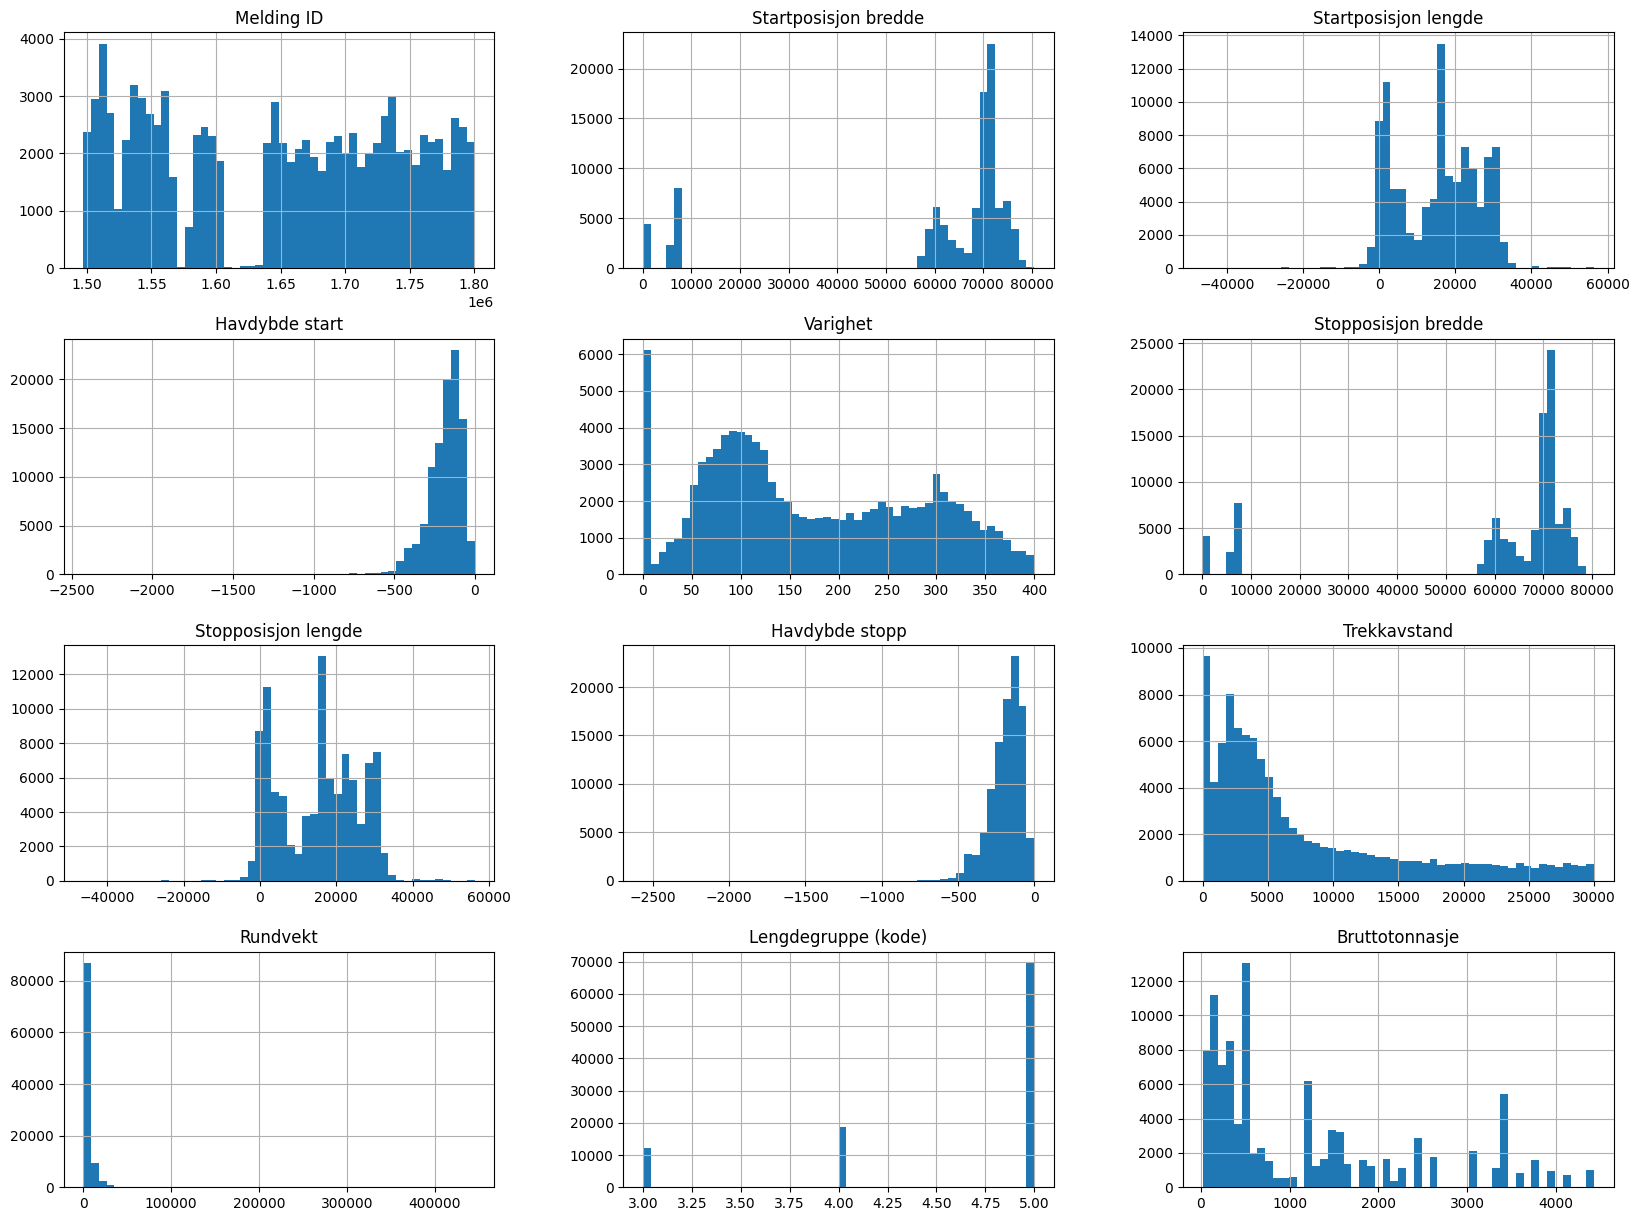

In [20]:
#looking at distribution of all numerical columns
df.hist(bins=50, figsize=(20,15))
plt.show()


Art FAO
Torsk    40535
Sei      30344
Hyse     29421
Name: count, dtype: int64


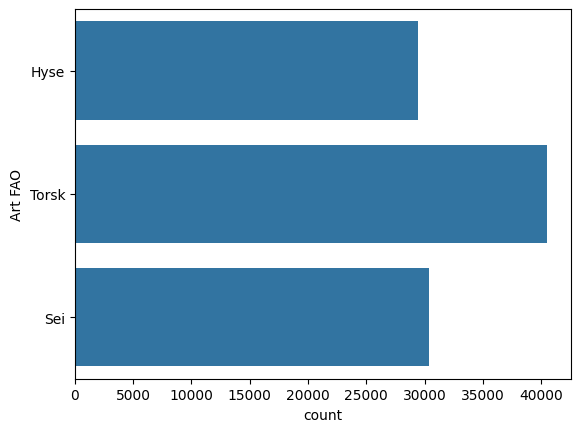

In [21]:
#counting species
print(df['Art FAO'].value_counts())
#plotting species
sns.countplot(df['Art FAO'])
plt.show()

In [22]:
# Pivoting table

# Pivoting table so rows that are information about the same session are put together
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")
df = df.pivot_table(index=['Melding ID', 'Startposisjon bredde', 'Startposisjon lengde',
                           'Havdybde start', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand',
                            'Redskap FAO','Hovedart FAO','Bruttotonnasje' ], columns='Art FAO', values='Rundvekt', aggfunc='sum').reset_index()
# # This creates a lot of nan values which we fill with 0
df.info()
# df.dropna(inplace=True)
#counting nan values
df.isnull().sum().sum()
#locating nan values


Before pre-processing the dataset has 18 columns and 100300 rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47330 entries, 0 to 47329
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Melding ID            47330 non-null  int64  
 1   Startposisjon bredde  47330 non-null  int32  
 2   Startposisjon lengde  47330 non-null  int32  
 3   Havdybde start        47330 non-null  int64  
 4   Varighet              47330 non-null  int32  
 5   Stopposisjon bredde   47330 non-null  int32  
 6   Stopposisjon lengde   47330 non-null  int32  
 7   Havdybde stopp        47330 non-null  int64  
 8   Trekkavstand          47330 non-null  int32  
 9   Redskap FAO           47330 non-null  object 
 10  Hovedart FAO          47330 non-null  object 
 11  Bruttotonnasje        47330 non-null  int32  
 12  Hyse                  29415 non-null  float64
 13  Sei                   30339 non-null  float64
 14  Torsk

41709

In [23]:
df.isnull().sum()

Art FAO
Melding ID                  0
Startposisjon bredde        0
Startposisjon lengde        0
Havdybde start              0
Varighet                    0
Stopposisjon bredde         0
Stopposisjon lengde         0
Havdybde stopp              0
Trekkavstand                0
Redskap FAO                 0
Hovedart FAO                0
Bruttotonnasje              0
Hyse                    17915
Sei                     16991
Torsk                    6803
dtype: int64

In [24]:
#using knnimputer to fill nan values in Hyse, Sei and Torsk columns
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# df[['Hyse', 'Sei', 'Torsk']] = imputer.fit_transform(df[['Hyse', 'Sei', 'Torsk']])
# df.isnull().sum().sum()

#filling nan values with the median of Hyse, Sei, Torsk
# df['Hyse'] = df['Hyse'].fillna(df['Hyse'].median())
# df['Sei'] = df['Sei'].fillna(df['Sei'].median())
# df['Torsk'] = df['Torsk'].fillna(df['Torsk'].median())
# df.isnull().sum().sum()

#using MissForest to fill nan values
# from missforest.missforest import MissForest
# imputer = MissForest()
# df[['Hyse', 'Sei', 'Torsk']] = imputer.fit_transform(df[['Hyse', 'Sei', 'Torsk']])
# df.isnull().sum().sum()


#dropping nan values
# df.dropna(inplace=True)
#filling nan with 0
df.fillna(0, inplace=True)
df.isnull().sum().sum()


0

C:\Users\brohn\AppData\Local\Temp\ipykernel_26208\55482528.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Hyse'], label='Hyse', shade=True)


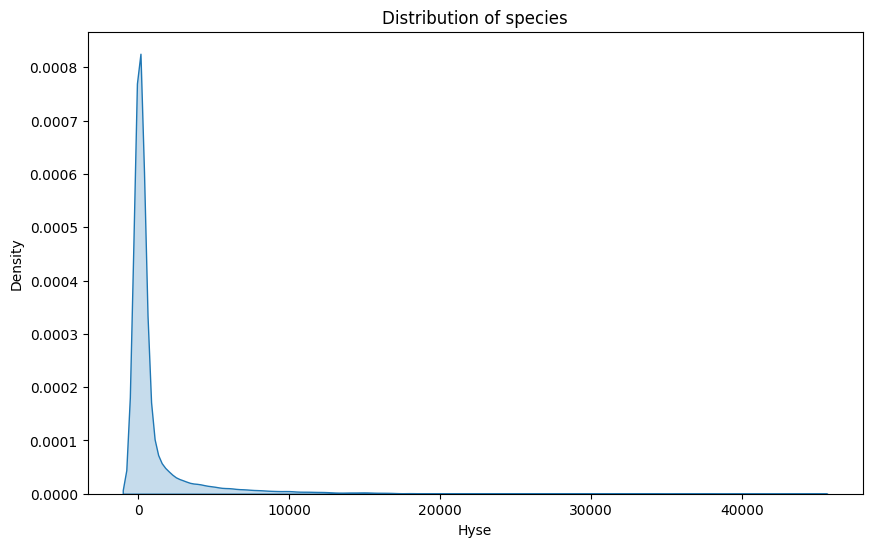

C:\Users\brohn\AppData\Local\Temp\ipykernel_26208\55482528.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Sei'], label='Sei', shade=True)


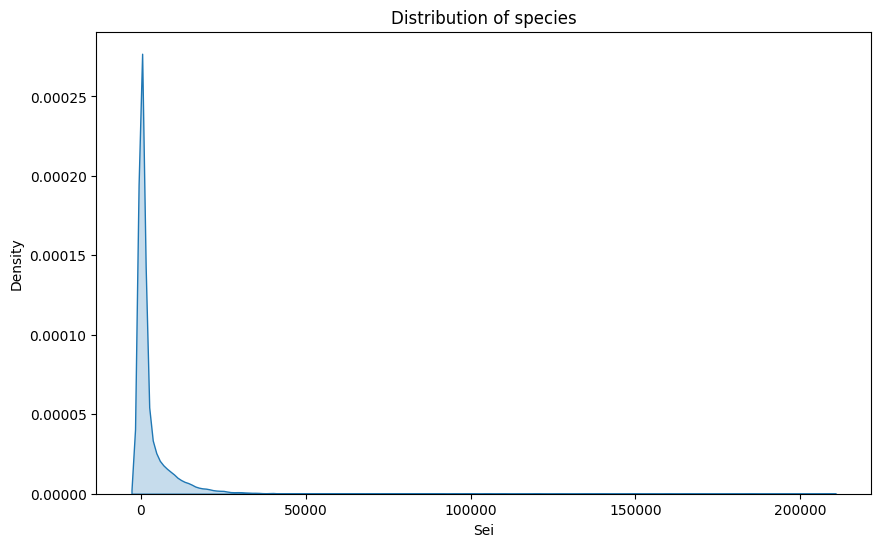

C:\Users\brohn\AppData\Local\Temp\ipykernel_26208\55482528.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Torsk'], label='Torsk', shade=True)


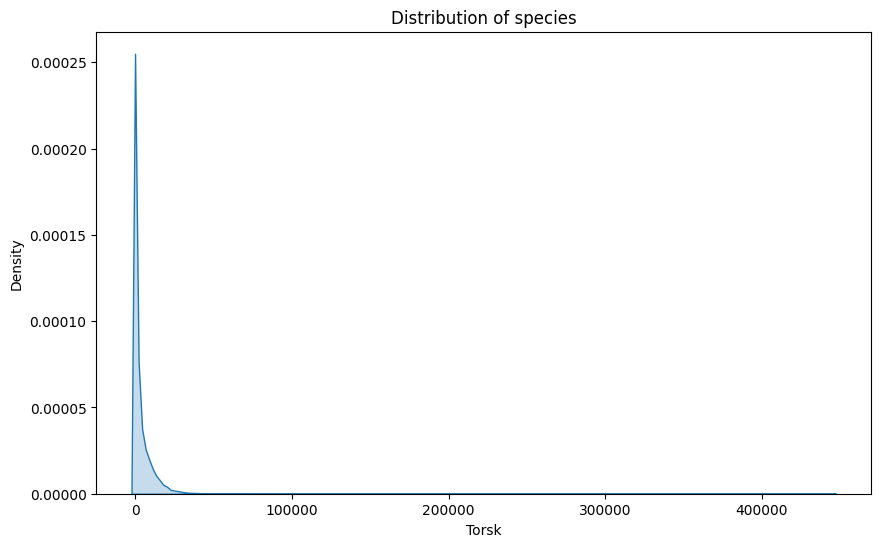

In [25]:
#plotting the distribution of the species
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Hyse'], label='Hyse', shade=True)
plt.title('Distribution of species')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Sei'], label='Sei', shade=True)
plt.title('Distribution of species')

plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Torsk'], label='Torsk', shade=True)
plt.title('Distribution of species')
plt.show()

In [26]:
#cutting off every value above 10000 in Hyse, Sei and Torsk
df = df[df['Hyse'] <= 15000]
df = df[df['Sei'] <= 15000]
df = df[df['Torsk'] <= 15000]


In [27]:
#unqiue values in columns
df.nunique()

Art FAO
Melding ID              20130
Startposisjon bredde    12186
Startposisjon lengde    18283
Havdybde start            700
Varighet                  401
Stopposisjon bredde     12313
Stopposisjon lengde     18442
Havdybde stopp            742
Trekkavstand            16960
Redskap FAO                24
Hovedart FAO               47
Bruttotonnasje            296
Hyse                     3789
Sei                      5895
Torsk                    7208
dtype: int64

In [28]:
#counting the dropped values after processing
print(f"After pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")
df.head()

After pre-processing the dataset has 15 columns and 41795 rows


Art FAO,Melding ID,Startposisjon bredde,Startposisjon lengde,Havdybde start,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Hovedart FAO,Bruttotonnasje,Hyse,Sei,Torsk
0,1497178,7491,15868,-403,267,74901,16248,-277,11096,"Bunntrål, otter",Hyse,1476,9118.0,67.0,6651.0
1,1497178,74883,16056,-346,315,74924,15742,-496,10215,"Bunntrål, otter",Hyse,1476,12432.0,68.0,5097.0
2,1497178,74885,16048,-335,295,74914,15969,-334,3970,"Bunntrål, otter",Hyse,1476,9594.0,134.0,8510.0
3,1497178,74931,15785,-443,243,74926,15894,-358,3214,"Bunntrål, otter",Torsk,1476,6758.0,0.0,7022.0
4,1497229,67826,12967,-71,72,67829,12933,-54,1471,Snurrevad,Torsk,51,0.0,0.0,1800.0


In [29]:
# Scaling and one-hot encoding features
#importing minmaxscaler

from sklearn.preprocessing import MinMaxScaler
# Scale the numerical features. During testing of the models it seemed to have little to no difference for the random forest model.
# But we keep them this way in case other models find them useful.
num_feat = df[['Melding ID', 'Havdybde start',
        'Varighet', 'Havdybde stopp', 'Trekkavstand', 'Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(num_feat)
scaled_df = pd.DataFrame(scaled_features, columns=num_feat.columns)

In [30]:
scaled_df.head()

Art FAO,Melding ID,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Startposisjon bredde,Startposisjon lengde,Stopposisjon bredde,Stopposisjon lengde
0,0.000000,0.834432,0.6675,0.892356,0.369904,0.092394,0.604966,0.931451,0.609888
1,0.000000,0.857908,0.7875,0.806942,0.340534,0.930092,0.606796,0.931737,0.604953
2,0.000000,0.862438,0.7375,0.870125,0.132347,0.930117,0.606718,0.931613,0.607167
3,0.000000,0.817957,0.6075,0.860764,0.107144,0.930689,0.604158,0.931762,0.606435
4,0.000168,0.971170,0.1800,0.979329,0.049038,0.842372,0.576729,0.843437,0.577556


In [31]:
#counting the instances  of each species Hyse, Sei, Torsk
print(df['Hyse'].value_counts())
print(df['Sei'].value_counts())

Hyse
0.0        15450
100.0       1056
50.0         752
200.0        681
300.0        531
           ...  
3684.0         1
11666.0        1
3702.0         1
9852.0         1
9370.0         1
Name: count, Length: 3789, dtype: int64
Sei
0.0        15116
100.0        646
50.0         522
200.0        495
1000.0       454
           ...  
10703.0        1
826.0          1
13790.0        1
8760.0         1
2130.0         1
Name: count, Length: 5895, dtype: int64


In [32]:
#dbscan for clustering
# from sklearn.cluster import DBSCAN


# #using dbscan
# dbscan = DBSCAN(eps=0.1, min_samples=100)
# dbscan.fit(scaled_df)
# #counting the clusters
# print(dbscan.labels_)
# print(np.unique(dbscan.labels_))

# #plotting the clusters
# plt.scatter(scaled_df['Torsk'], scaled_df['Havdybde start'], c=dbscan.labels_)
# plt.xlabel('Torsk')
# plt.ylabel('Havdybde Start')
# plt.title('DBSCAN')
# plt.show()

# #plotting more clusters
# plt.scatter(scaled_df['Sei'], scaled_df['Havdybde start'], c=dbscan.labels_)
# plt.xlabel('Sei')
# plt.ylabel('Havdybde Start')
# plt.title('DBSCAN')
# plt.show()

# #plotting more clusters torsk and bruttotonnasje
# plt.scatter(df['Hyse'], df['Havdybde start'], c=dbscan.labels_)
# plt.xlabel('Hyse')
# plt.ylabel('Havdybde Start')
# plt.title('DBSCAN')
# plt.show()


In [33]:
# One-hot encode the categorical features. 
from sklearn.preprocessing import OneHotEncoder
cat_feat = df[['Hovedart FAO', 'Bruttotonnasje', 'Redskap FAO']]
encoder = OneHotEncoder()
enc_feat= encoder.fit_transform(cat_feat)
enc_df = pd.DataFrame(enc_feat.toarray(), columns=encoder.get_feature_names_out())

# Concatonate the changed features
features = pd.concat([enc_df, scaled_df], axis=1)
# Isolate the targets
targets = df[['Hyse', 'Sei', 'Torsk']]
features.head()

scaler = MinMaxScaler()
scaled_targets = scaler.fit_transform(targets)

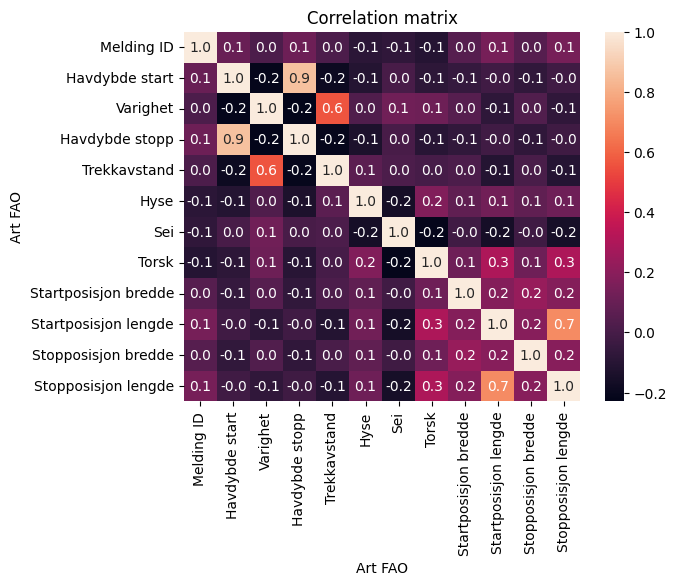

In [34]:
df_corr = df[['Melding ID', 'Havdybde start','Varighet', 'Havdybde stopp', 'Trekkavstand', 'Hyse', 'Sei', 'Torsk','Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde' ]]
#plotting the correlation matrix
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f" )  #.1ft for using one decimal
plt.title('Correlation matrix')
plt.show() #the correlation matrix does not really tell us any strong relationships between relevant features. The non-linear relationships could still be useful for the model though.

#### Testing models and further exploration of data

Because decision trees are good when there is a different mix of features we have decided to use random forest to even out the downsides of single decision trees. As en extension of that we have decided to use a gradient boosting model as our second model.

##### Baseline RandomForestRegressor

In [35]:
df.shape

(41795, 15)

In [36]:
#using random forest without optimization for creating a baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


X_train, X_test, y_train, y_test = train_test_split(scaled_df, scaled_targets, test_size=0.02, random_state=seed)
rfr = RandomForestRegressor(n_estimators=250, max_features=25, max_depth=40)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}")
print(f"RMSE: {rmse}")

R2: 0.624013034516839
RMSE: 0.1314545985405954


##### RandomForestRegressor with encoded values + scaled

In [37]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(features, scaled_targets, random_state=seed)

# After testing various parameters we chose to go with n_estimators=200, max_features=25, max_depth=40 for this dataset
# The features seemed to be best from 20 upwards. Depth was best between 25-40, from 45 it seemed to go down in performance befroe picking it up again at 70.
# We only tested up to 300 estimators, and it seemed to increase performance slightly all the way up, but for running time we are currently using 200.
rfr = RandomForestRegressor(n_estimators=300, max_features=50, max_depth=50)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_oneHot = r2_score(y_test, y_pred)
print(f"R2: {r2_oneHot}")
print(f"RMSE: {rmse}")

R2: 0.701745333833026
RMSE: 0.1162718424916555


(41795, 376)

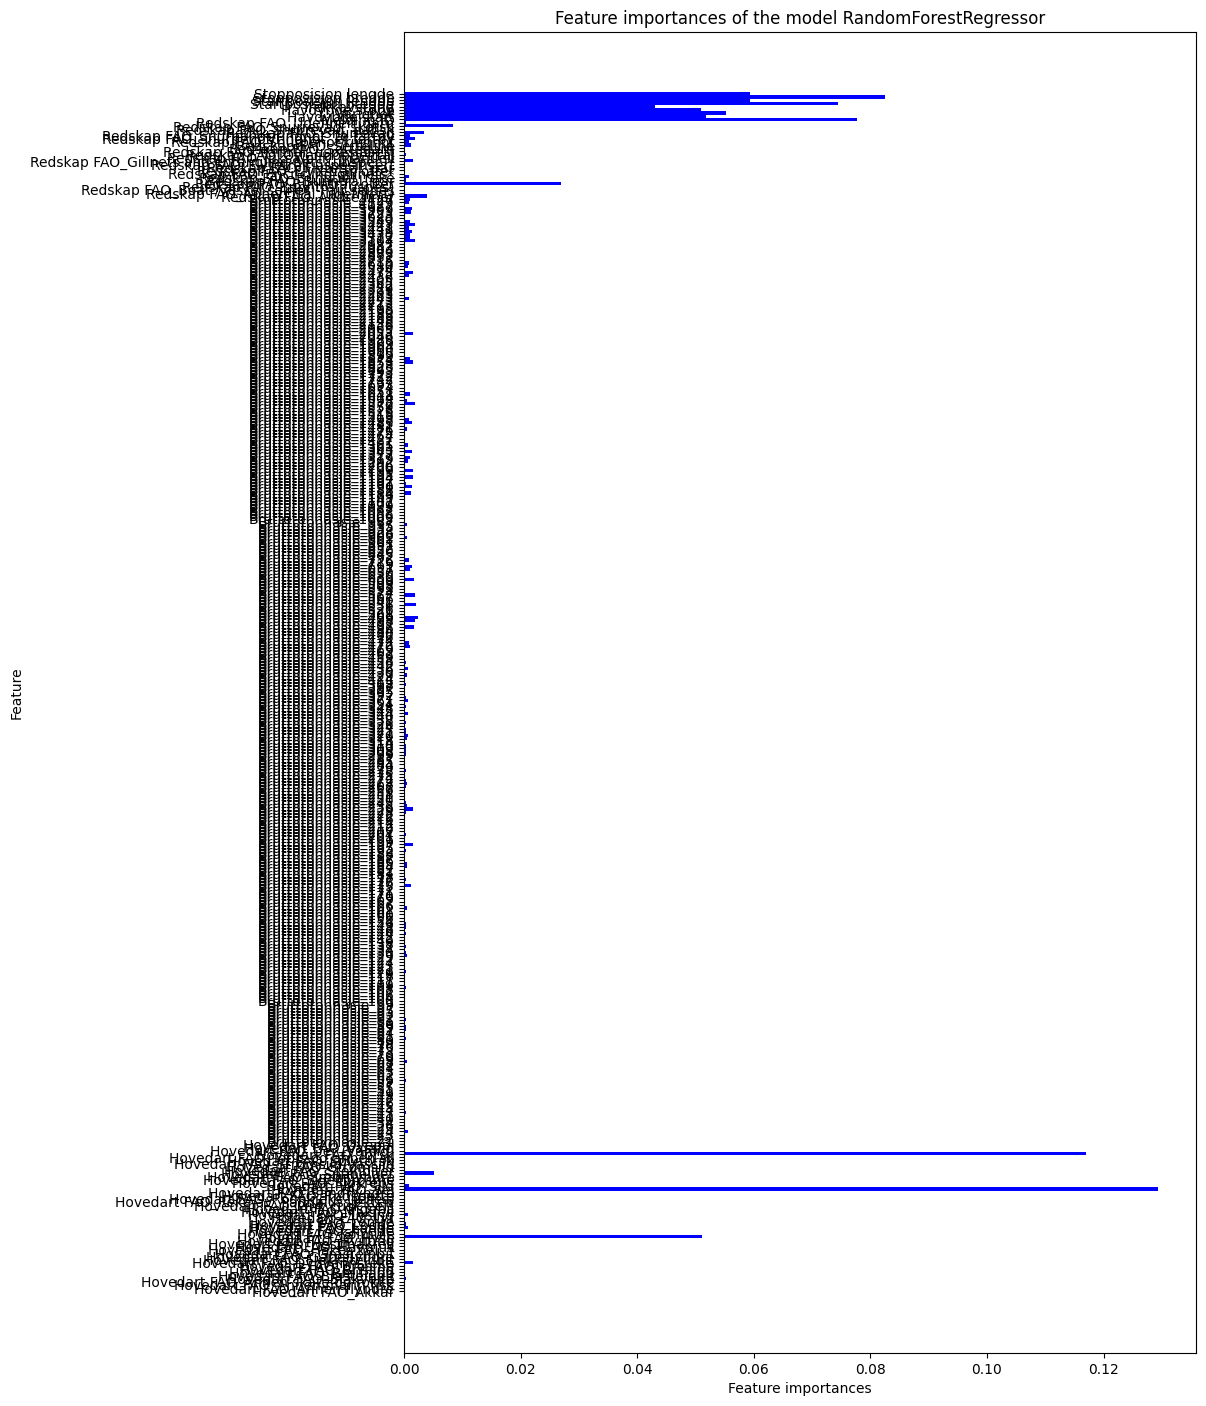

In [38]:

def plot_feature_importances(model, feature_columns):
    n_features = len(feature_columns.columns)
    feature_indices = feature_columns.columns.tolist()
    feature_importances = model.feature_importances_
    #adding if statement to remove the one-hot encoded columns that have no importance



    fig = plt.figure(figsize=(12,14))
    plt.subplot(111)
    plt.barh(range(n_features), feature_importances, height=1, color='b', align='center')
    plt.yticks(np.arange(n_features), feature_indices[:n_features])
    plt.xlabel("Feature importances")
    plt.ylabel("Feature")
    plt.title("Feature importances of the model {}".format(model.__class__.__name__))
    plt.tight_layout(pad=0.5)
plot_feature_importances(rfr, features)


features.shape
# This graph shows the feature importance of the randomforest model.
# A lot of the one-hot encoded features seem to have no importance. We tried collapsing all the seemingly irrelevant ones into a single column.
# That seemed to worsen the R2 score from 0.637-642 to around 0.44 so we've decided to keep them for now even though this graph seems to indicate their lack of importance.

##### GradientBoostingRegressor with encoded + scaled values


In [39]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.multioutput import MultiOutputRegressor
# # From testing: putting the learning rate at 0.3 or above seems to make results worse. Setting depth over 10 seems to do the same and increase the runtime a lot.
# # We will do some more rounds of testing, but for now are settling on a depth of 7, learning rate of 0.8. Number of estimators hasent been tested yet, so for now its a standard of 100.

# X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)

# base_estimator = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=seed)
        
# multioutput_regressor = MultiOutputRegressor(base_estimator)
        
# multioutput_regressor.fit(X_train, y_train)
        
# y_pred = multioutput_regressor.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2_gradient = r2_score(y_test, y_pred)
# print(f"R2: {r2_gradient}")

### Xtreme Gradient Boosting

In [40]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
#using XG boost with encoded + scaled features
# Split the data into training and testing sets
y_train = y_train.astype(int)
y_test = y_test.astype(int)

X_train, X_test, y_train, y_test = train_test_split(features, scaled_targets, random_state=seed)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 40, alpha = 10, n_estimators = 200, )

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2_xg = r2_score(y_test, preds)
print(f"R2: {r2_xg}, RMSE: {rmse}.")

R2: 0.66631766398278, RMSE: 0.12247669573051247.


In [48]:
# Decided to use the MLPRegressor model as the deep learning model, since it is the most relevant for our regression problem. Using one hot encoded values, continuous values and scaled values. 
from sklearn.neural_network import MLPRegressor


X_train, X_test, y_train, y_test = train_test_split(features, scaled_targets, random_state=seed)
#creating the model
model = MLPRegressor(random_state=seed, max_iter=1000, verbose=True, hidden_layer_sizes=(100, 50, 25, 10), activation='relu', solver='adam', batch_size='auto', learning_rate='adaptive', learning_rate_init=0.09,shuffle=True,  early_stopping=True)
model.fit(X_train, y_train)
#currently in testing phase of understanding and using the correct parameters for the model.
#predicting the test data
y_pred = model.predict(X_test)
print(y_pred.round(2))
#returning the result
r2_mlp = r2_score(y_test, y_pred)
print(f"R2 score: {r2_mlp}")

Iteration 1, loss = 0.61259151
Validation score: 0.109436
Iteration 2, loss = 0.01582109
Validation score: 0.239828
Iteration 3, loss = 0.01534951
Validation score: 0.234519
Iteration 4, loss = 0.01551290
Validation score: 0.275977
Iteration 5, loss = 0.01518707
Validation score: 0.220615
Iteration 6, loss = 0.01504020
Validation score: 0.274530
Iteration 7, loss = 0.01508826
Validation score: 0.268583
Iteration 8, loss = 0.01903525
Validation score: -0.040651
Iteration 9, loss = 0.02202978
Validation score: -0.007777
Iteration 10, loss = 0.02202081
Validation score: -0.035153
Iteration 11, loss = 0.02192964
Validation score: -0.013059
Iteration 12, loss = 0.02203749
Validation score: -0.018908
Iteration 13, loss = 0.02199565
Validation score: -0.017292
Iteration 14, loss = 0.02192662
Validation score: -0.026956
Iteration 15, loss = 0.02203302
Validation score: -0.195382
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[[ 0.17 -0.08  0.36]
 [

Text(0.5, 1.0, 'R2 scores of the models')

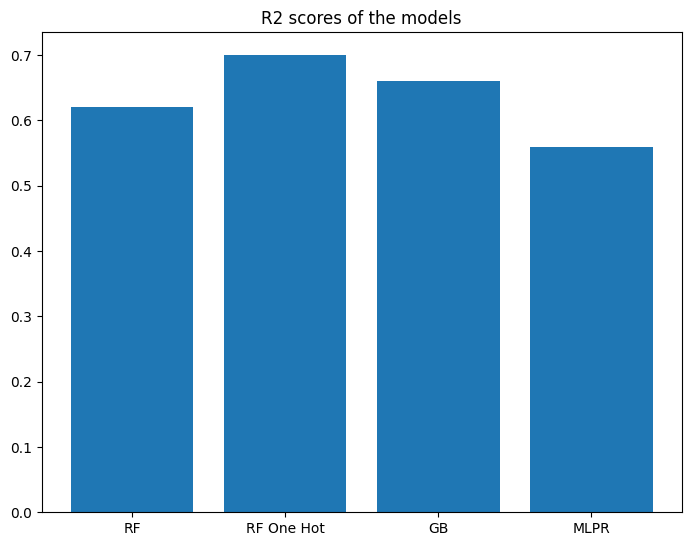

In [47]:
#plotting all the r2 scores from each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['RF','RF One Hot', 'GB', 'MLPR']
r2_scores = [0.62,0.70,0.66,0.56]
ax.bar(models,r2_scores)
plt.title('R2 scores of the models')

##### This function is for keeping track of the models we have tested and their scores

In [ ]:
def result():
    with open('results.txt', 'w') as f:
        f.write(f"Multioutputregression: {r2_mlp}\n")
        f.write(f"RandomForest Baseline: {r2}\n")
        f.write(f"GradientBoosting: {r2_xg}\n")
        f.write(f"RandomForest One Hot: {r2_oneHot}\n") 
        # f.write(f"XGBoost: {r2_xg}\n")
result()

##### Creating our own deep learning model with pytorch

In [ ]:
# -*- coding: utf-8 -*-
# import torch
# import math


# # Create Tensors to hold input and outputs.
# x = torch.linspace(-math.pi, math.pi, 2000)
# y = torch.sin(x)

# # For this example, the output y is a linear function of (x, x^2, x^3), so
# # we can consider it as a linear layer neural network. Let's prepare the
# # tensor (x, x^2, x^3).
# p = torch.tensor([1, 2, 3])
# xx = x.unsqueeze(-1).pow(p)

# # In the above code, x.unsqueeze(-1) has shape (2000, 1), and p has shape
# # (3,), for this case, broadcasting semantics will apply to obtain a tensor
# # of shape (2000, 3) 

# # Use the nn package to define our model as a sequence of layers. nn.Sequential
# # is a Module which contains other Modules, and applies them in sequence to
# # produce its output. The Linear Module computes output from input using a
# # linear function, and holds internal Tensors for its weight and bias.
# # The Flatten layer flatens the output of the linear layer to a 1D tensor,
# # to match the shape of `y`.
# model = torch.nn.Sequential(
#     torch.nn.Linear(3, 1),
#     torch.nn.Flatten(0, 1)
# )
# # The nn package also contains definitions of popular loss functions; in this
# # case we will use Mean Squared Error (MSE) as our loss function.
# loss_fn = torch.nn.MSELoss(reduction='sum')

# learning_rate = 1e-6
# for t in range(2000):

#     # Forward pass: compute predicted y by passing x to the model. Module objects
#     # override the __call__ operator so you can call them like functions. When
#     # doing so you pass a Tensor of input data to the Module and it produces
#     # a Tensor of output data.
#     y_pred = model(xx)

#     # Compute and print loss. We pass Tensors containing the predicted and true
#     # values of y, and the loss function returns a Tensor containing the
#     # loss.
#     loss = loss_fn(y_pred, y)
#     if t % 100 == 99:
#         print(t, loss.item())

#     # Zero the gradients before running the backward pass.
#     model.zero_grad()

#     # Backward pass: compute gradient of the loss with respect to all the learnable
#     # parameters of the model. Internally, the parameters of each Module are stored
#     # in Tensors with requires_grad=True, so this call will compute gradients for
#     # all learnable parameters in the model.
#     loss.backward()

#     # Update the weights using gradient descent. Each parameter is a Tensor, so
#     # we can access its gradients like we did before.
#     with torch.no_grad():
#         for param in model.parameters():
#             param -= learning_rate * param.grad

# # You can access the first layer of `model` like accessing the first item of a list
# linear_layer = model[0]

# # For linear layer, its parameters are stored as `weight` and `bias`.
# print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

dropp kommentarer. except for tekniske ting
vise dataen underveis
dropna, påstander om hvorfor vi dropper de, bevis 
vise distribusjon av outliers
fillNA, groupBy, meldingsid, startstidspunkt
robustScaler, hvorfor vi bruker det, outliers
scalingData for modellene, forklar
gradientBoosting, scaling data hvorfor? Bedre optimum, forklare MultioutputRegressor







